<h1> MinMaxScaled data</h1>

In [148]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

np.random.seed(40)

data = pd.read_csv("../data/our_data.csv")
prep_data = pd.read_csv("../data/our_data_preprocessed_MinMaxScaler.csv")

In [149]:
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

def count_silhouette_scores(X, k_max):
    scores = []
    for k in range(2, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        labels = kmeans.labels_
        score = silhouette_score(X, labels)
        scores.append(score)
    return scores

def count_calinski_harabasz_scores(X, k_max):
    scores = []
    for k in range(2, k_max + 1):  # Calinski-Harabasz score nie działa dla k=1
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        labels = kmeans.labels_
        score = calinski_harabasz_score(X, labels)
        scores.append(score)
    return scores

def count_davies_bouldin_scores(X, k_max):
    scores = []
    for k in range(2, k_max + 1):  # Davies-Bouldin score nie działa dla k=1
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        labels = kmeans.labels_
        score = davies_bouldin_score(X, labels)
        scores.append(score)
    return scores

def show_scores(data, cluster_col):
    print(cluster_col)
    print("Silhouette Score: ", silhouette_score(data.drop(cluster_col, axis=1), data[cluster_col]))
    print("Calinski-Harabasz Score: ", calinski_harabasz_score(data.drop(cluster_col, axis=1), data[cluster_col]))
    print("Davies-Bouldin Score: ", davies_bouldin_score(data.drop(cluster_col, axis=1), data[cluster_col]))

<h1> Dimensionality reduction by UMAP <h1>

In [150]:
import umap
import optuna
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances

random_seed = 42

sampler = optuna.samplers.TPESampler(seed=random_seed)

def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 5, 80)
    min_dist = trial.suggest_uniform('min_dist', 0.0, 0.99)
    n_components = trial.suggest_int('n_components', 2, 10)
    
    umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                           n_components=n_components, random_state=random_seed)
    embedding = umap_model.fit_transform(prep_data)
    
    dists = pairwise_distances(embedding)
    score = np.mean(np.std(dists, axis=1)) 
    
    return score

study = optuna.create_study(direction='minimize', sampler=sampler) 
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best hyperparameters:: ", best_params)

umap_best = umap.UMAP(n_neighbors=best_params['n_neighbors'],
                      min_dist=best_params['min_dist'],
                      n_components=best_params['n_components'],
                      random_state=random_seed)
data_umap = umap_best.fit_transform(prep_data)

df_umap = pd.DataFrame(data=data_umap, columns=[f'UMAP{i+1}' for i in range(best_params['n_components'])])

print(df_umap.head())


[I 2024-05-30 14:53:36,350] A new study created in memory with name: no-name-a5bb0533-553d-4b52-aa18-4eda5e8e5c62
/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_87271/2497539388.py:13: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/Users/katebokhan/anaconda3/envs/6.86x/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

[I 2024-05-30 14:53:39,239] Trial 0 finished with value: 3.4823923110961914 and parameters: {'n_neighbors': 33, 'min_dist': 0.941207163345817, 'n_components': 8}. Best is trial 0 with value: 3.4823923110961914.
/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_87271/2497539388.py:13: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/

Best hyperparameters::  {'n_neighbors': 75, 'min_dist': 0.9475639792997835, 'n_components': 10}
       UMAP1     UMAP2      UMAP3     UMAP4     UMAP5     UMAP6     UMAP7  \
0  11.609584 -0.375369  10.064499  4.923772  4.392858  2.219012  6.034694   
1  11.821470  1.094820   7.695897  5.223737  5.516733  0.256395  4.687795   
2   9.789541  5.618619   8.800139  5.107861  1.658512  3.752443  4.810897   
3   4.059217  3.270250   8.983952  4.142937  4.009784  2.071321  5.517136   
4   3.944983  4.064081   9.098583  3.923524  4.337826  2.285083  6.224695   

      UMAP8     UMAP9    UMAP10  
0  5.556508  8.948442  4.274636  
1  5.955564  9.059235  3.972798  
2  8.714489  8.101164  5.208452  
3  9.498995  9.326948  3.667208  
4  9.384715  8.237402  4.348031  


### Searching for the best number of clusters

/Users/katebokhan/anaconda3/envs/6.86x/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/katebokhan/anaconda3/envs/6.86x/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/katebokhan/anaconda3/envs/6.86x/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/katebokhan/anaconda3/envs/6.86x/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/katebokha

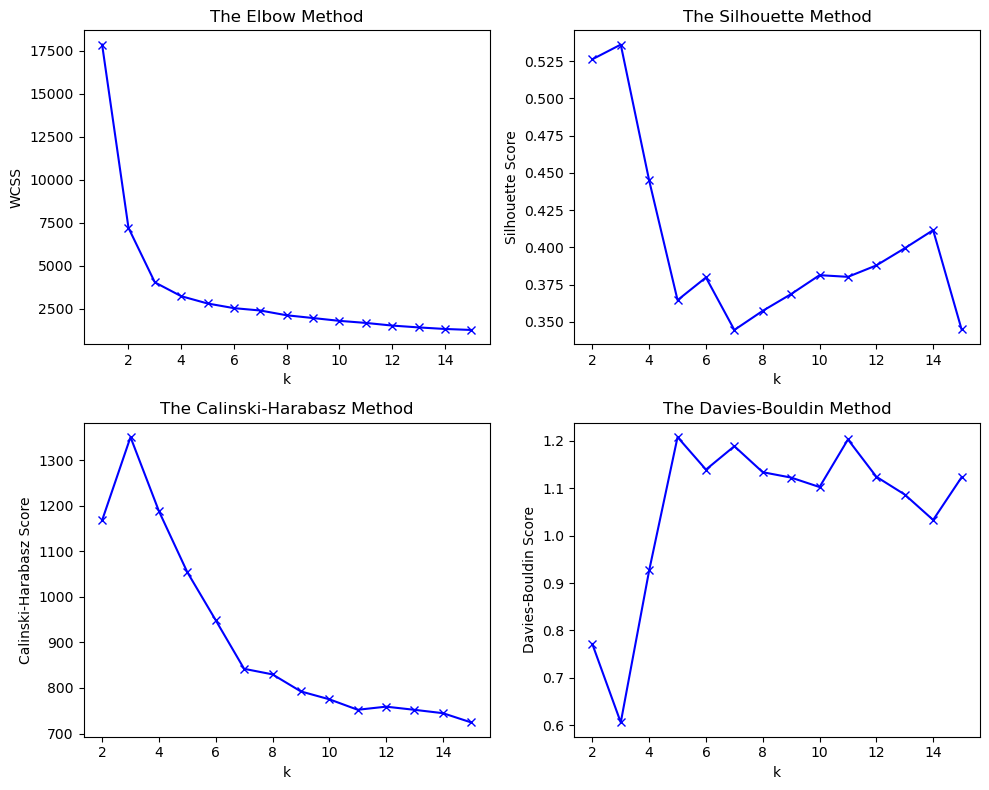

In [151]:
k_max = 15
wcss_vec = count_wcss_scores(df_umap, k_max)
silhouette_vec = count_silhouette_scores(df_umap, k_max)
calinski_harabasz_vec = count_calinski_harabasz_scores(df_umap, k_max)
davies_bouldin_vec = count_davies_bouldin_scores(df_umap, k_max)

x_ticks_wcss = list(range(1, len(wcss_vec) + 1))
x_ticks_silhouette = list(range(2, len(silhouette_vec) + 2))
x_ticks_calinski_harabasz = list(range(2, len(calinski_harabasz_vec) + 2))
x_ticks_davies_bouldin = list(range(2, len(davies_bouldin_vec) + 2))

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

#wcss
axs[0, 0].plot(x_ticks_wcss, wcss_vec, 'bx-')
axs[0, 0].set_xlabel('k')
axs[0, 0].set_ylabel('WCSS')
axs[0, 0].set_title('The Elbow Method')

#silhouette
axs[0, 1].plot(x_ticks_silhouette, silhouette_vec, 'bx-')
axs[0, 1].set_xlabel('k')
axs[0, 1].set_ylabel('Silhouette Score')
axs[0, 1].set_title('The Silhouette Method')

#Calinski-Harabasz
axs[1, 0].plot(x_ticks_calinski_harabasz, calinski_harabasz_vec, 'bx-')
axs[1, 0].set_xlabel('k')
axs[1, 0].set_ylabel('Calinski-Harabasz Score')
axs[1, 0].set_title('The Calinski-Harabasz Method')

#Davies-Bouldin
axs[1, 1].plot(x_ticks_davies_bouldin, davies_bouldin_vec, 'bx-')
axs[1, 1].set_xlabel('k')
axs[1, 1].set_ylabel('Davies-Bouldin Score')
axs[1, 1].set_title('The Davies-Bouldin Method')

plt.tight_layout()
plt.show()

the best number of clusters here is definetely 3

<h1> KMeans </h1>

In [161]:
from sklearn.cluster import KMeans

if 'cluster' in df_umap.columns:
    df_umap = df_umap.drop('cluster', axis=1)

kmeans  = KMeans(n_clusters=3, random_state=0)

df_umap['cluster'] = kmeans.fit_predict(df_umap)
data['cluster'] = df_umap['cluster']

/Users/katebokhan/anaconda3/envs/6.86x/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [162]:
show_scores(df_umap, 'cluster')

cluster
Silhouette Score:  0.5360302
Calinski-Harabasz Score:  1350.5186805091505
Davies-Bouldin Score:  0.6061432453306356


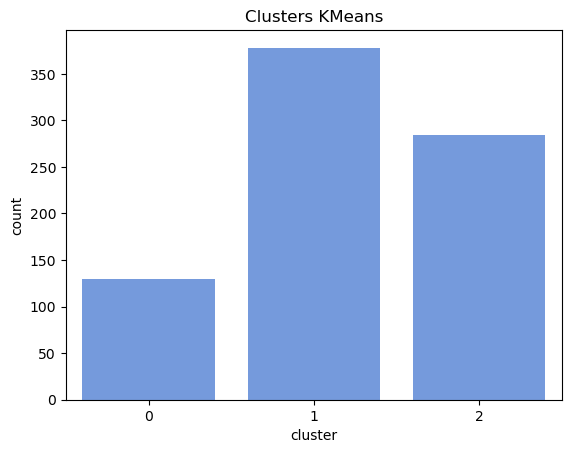

In [167]:
df_umap['cluster'].value_counts()

import matplotlib.pyplot as plt
import seaborn as sns

#clusters barplot
sns.countplot(data=df_umap, x='cluster', color='cornflowerblue')
plt.title('Clusters KMeans')
plt.show()


plot with pca

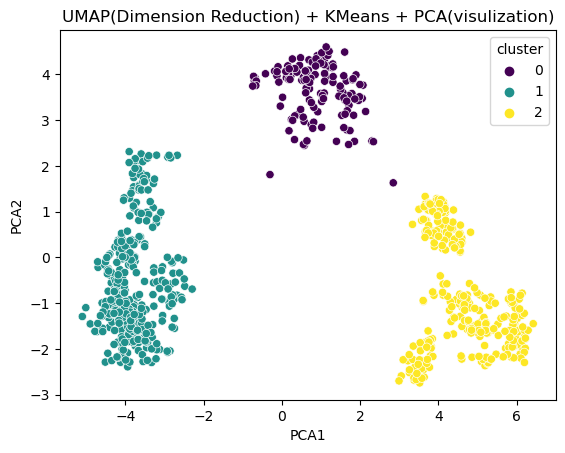

In [168]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(df_umap.drop('cluster', axis=1))

df_pca = pd.DataFrame(data=data_pca, columns=['PCA1', 'PCA2'])

df_pca['cluster'] = df_umap['cluster']

sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='cluster', palette='viridis')
plt.title('UMAP(Dimension Reduction) + KMeans + PCA(visulization)')
plt.show()

plot with t-sne

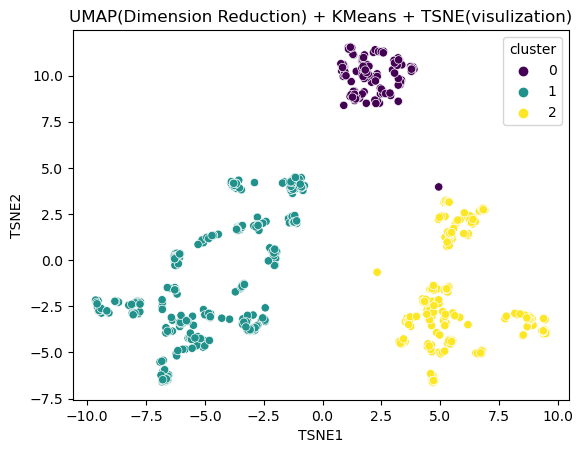

In [170]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, perplexity=90, n_iter=300)
data_tsne = tsne.fit_transform(df_umap.drop('cluster', axis=1))

df_tsne = pd.DataFrame(data=data_tsne, columns=['TSNE1', 'TSNE2'])

df_tsne['cluster'] = df_umap['cluster']

sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='cluster', palette='viridis')
plt.title('UMAP(Dimension Reduction) + KMeans + TSNE(visulization)')
plt.show()

plot with Multidimensional Scaling (MDS)

/Users/katebokhan/anaconda3/envs/6.86x/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



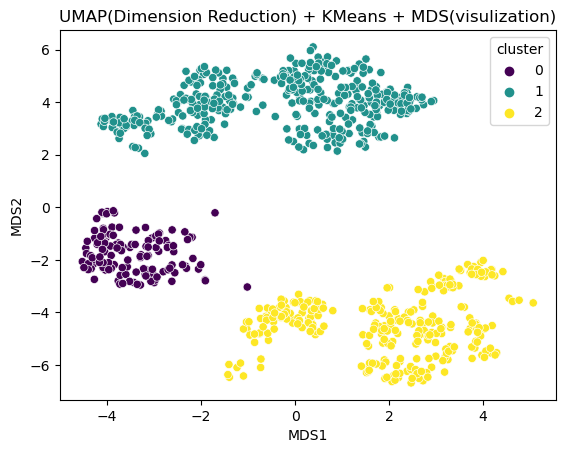

In [171]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=0)
data_mds = mds.fit_transform(df_umap.drop('cluster', axis=1))

df_mds = pd.DataFrame(data=data_mds, columns=['MDS1', 'MDS2'])

df_mds['cluster'] = df_umap['cluster']

sns.scatterplot(data=df_mds, x='MDS1', y='MDS2', hue='cluster', palette='viridis')
plt.title('UMAP(Dimension Reduction) + KMeans + MDS(visulization)')
plt.show()

<h1> Agglomerative Clustering </h1>

In [187]:
from sklearn.cluster import AgglomerativeClustering

if 'cluster' in df_umap.columns:
    df_umap = df_umap.drop('cluster', axis=1)

agg = AgglomerativeClustering(n_clusters=3)

df_umap['cluster'] = agg.fit_predict(df_umap)
data['cluster'] = df_umap['cluster']

In [188]:
show_scores(df_umap, 'cluster')

cluster
Silhouette Score:  0.536028
Calinski-Harabasz Score:  1349.4105589710377
Davies-Bouldin Score:  0.6039325241474248


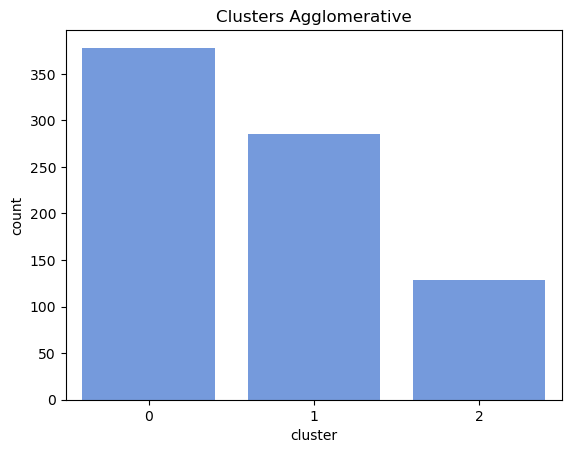

In [189]:
df_umap['cluster'].value_counts()

#clusters barplot
sns.countplot(data=df_umap, x='cluster', color='cornflowerblue')
plt.title('Clusters Agglomerative')
plt.show()


plot with pca

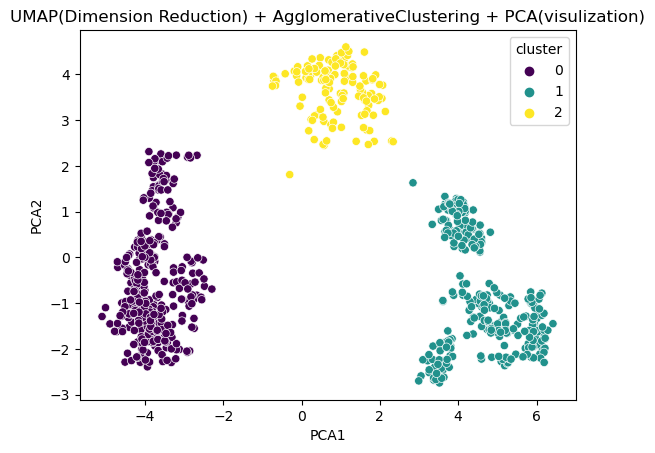

In [190]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(df_umap.drop('cluster', axis=1))

df_pca = pd.DataFrame(data=data_pca, columns=['PCA1', 'PCA2'])

df_pca['cluster'] = df_umap['cluster']

sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='cluster', palette='viridis')
plt.title('UMAP(Dimension Reduction) + AgglomerativeClustering + PCA(visulization)')
plt.show()

plot with t-sne

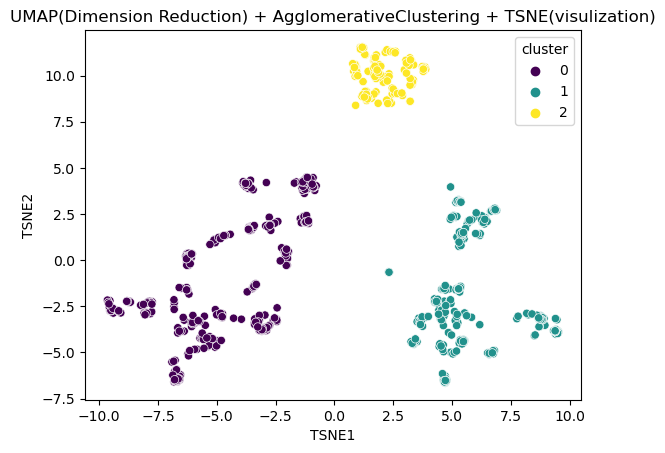

In [191]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, perplexity=90, n_iter=300)
data_tsne = tsne.fit_transform(df_umap.drop('cluster', axis=1))

df_tsne = pd.DataFrame(data=data_tsne, columns=['TSNE1', 'TSNE2'])

df_tsne['cluster'] = df_umap['cluster']

sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='cluster', palette='viridis')
plt.title('UMAP(Dimension Reduction) + AgglomerativeClustering + TSNE(visulization)')
plt.show()

plot with mds

/Users/katebokhan/anaconda3/envs/6.86x/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



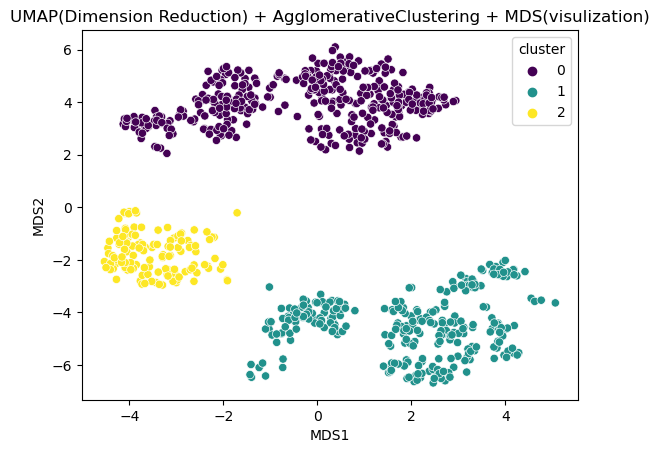

In [192]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=0)
data_mds = mds.fit_transform(df_umap.drop('cluster', axis=1))

df_mds = pd.DataFrame(data=data_mds, columns=['MDS1', 'MDS2'])

df_mds['cluster'] = df_umap['cluster']

sns.scatterplot(data=df_mds, x='MDS1', y='MDS2', hue='cluster', palette='viridis')
plt.title('UMAP(Dimension Reduction) + AgglomerativeClustering + MDS(visulization)')
plt.show()


<h1> DBSCAN </h1>

In [193]:
import optuna
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import pandas as pd
import numpy as np

np.random.seed(42)

if 'cluster' in df_umap.columns:
    df_umap = df_umap.drop('cluster', axis=1)

def objective(trial):
    eps = trial.suggest_loguniform('eps', 0.001, 7.0)
    min_samples = trial.suggest_int('min_samples', 2, 130)
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(df_umap)
    
    if len(set(cluster_labels)) > 1:
        silhouette = silhouette_score(df_umap, cluster_labels)
        calinski = calinski_harabasz_score(df_umap, cluster_labels)
        
        score = 0.5 * silhouette + 0.5 * calinski
    else:
        score = -1  
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

print(f'Best parameters: {study.best_params}')
print(f'Best score: {study.best_value}')

best_params = study.best_params

dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
df_umap['cluster'] = dbscan.fit_predict(df_umap)
data['cluster'] = df_umap['cluster']


[I 2024-05-30 17:09:54,715] A new study created in memory with name: no-name-af1d5787-5616-4ab3-a47d-589bd83ea57f
/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_87271/413198885.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2024-05-30 17:09:54,730] Trial 0 finished with value: -1.0 and parameters: {'eps': 0.001398115438626125, 'min_samples': 69}. Best is trial 0 with value: -1.0.
/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_87271/413198885.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2024-05-30 17:09:54,768] Trial 1 finished with value: 3.373843721939082 and parameters: {'eps': 0.5827283241692414, 'min_samples': 6}. Best is 

Best parameters: {'eps': 1.956876445417848, 'min_samples': 40}
Best score: 480.25676267654467


In [195]:
show_scores(df_umap, 'cluster')

cluster
Silhouette Score:  0.49322468
Calinski-Harabasz Score:  960.0203006726656
Davies-Bouldin Score:  0.6150387611468902


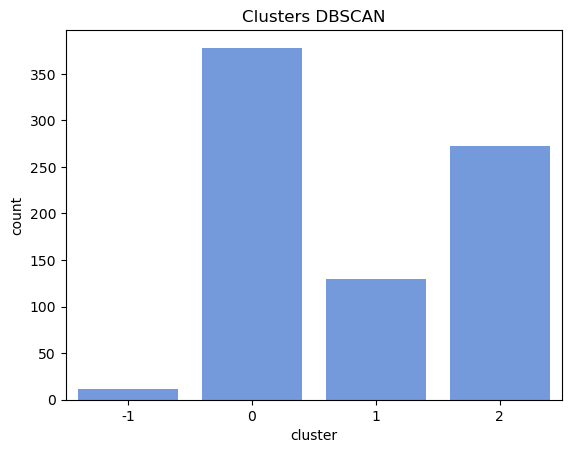

In [197]:
df_umap['cluster'].value_counts()

#clusters barplot
sns.countplot(data=df_umap, x='cluster', color='cornflowerblue')
plt.title('Clusters DBSCAN')
plt.show()

plot with pca

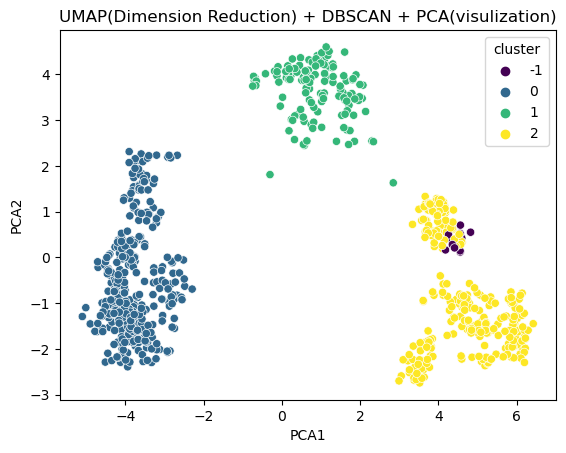

In [198]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(df_umap.drop('cluster', axis=1))

df_pca = pd.DataFrame(data=data_pca, columns=['PCA1', 'PCA2'])

df_pca['cluster'] = df_umap['cluster']

sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='cluster', palette='viridis')
plt.title('UMAP(Dimension Reduction) + DBSCAN + PCA(visulization)')
plt.show()

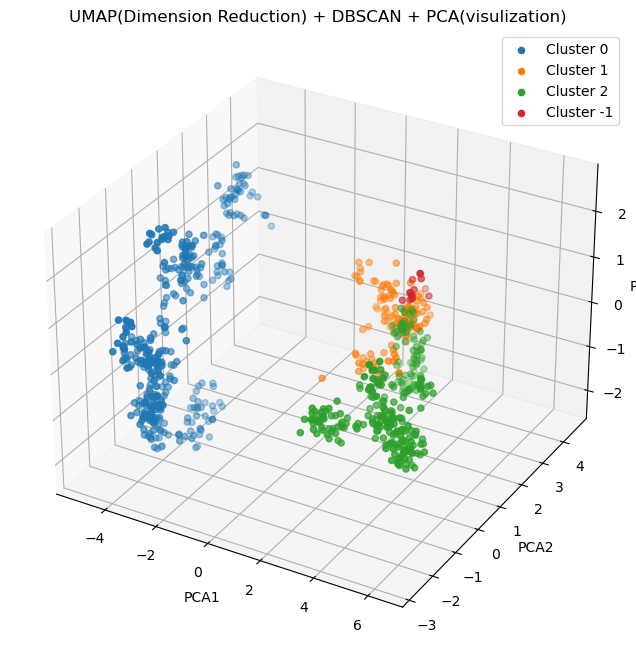

In [199]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

data_pca = pca.fit_transform(df_umap.drop('cluster', axis=1))

df_pca = pd.DataFrame(data=data_pca, columns=['PCA1', 'PCA2', 'PCA3'])

df_pca['cluster'] = df_umap['cluster']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in df_pca['cluster'].unique():
    df_cluster = df_pca[df_pca['cluster'] == cluster]
    ax.scatter(df_cluster['PCA1'], df_cluster['PCA2'], df_cluster['PCA3'], label=f'Cluster {cluster}')

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.title('UMAP(Dimension Reduction) + DBSCAN + PCA(visulization)')
plt.legend()


plot with t-sne

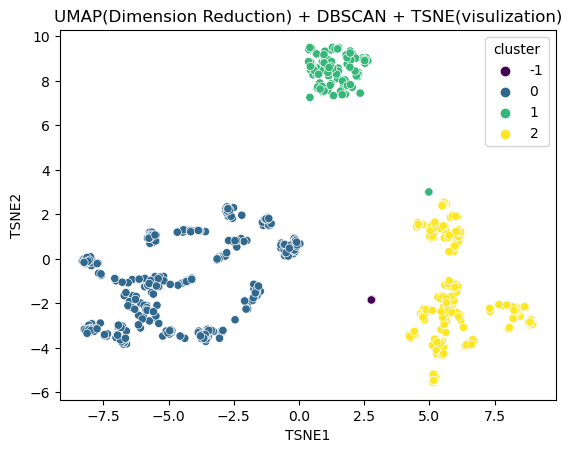

In [202]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, perplexity=120, n_iter=300)
data_tsne = tsne.fit_transform(df_umap.drop('cluster', axis=1))

df_tsne = pd.DataFrame(data=data_tsne, columns=['TSNE1', 'TSNE2'])

df_tsne['cluster'] = df_umap['cluster']

sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='cluster', palette='viridis')
plt.title('UMAP(Dimension Reduction) + DBSCAN + TSNE(visulization)')
plt.show()


plot with mds

/Users/katebokhan/anaconda3/envs/6.86x/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



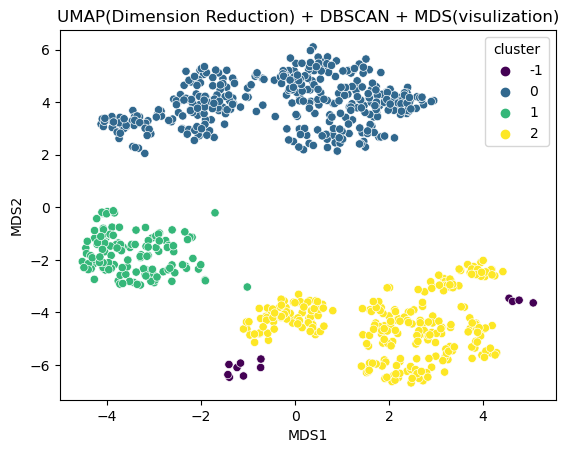

In [203]:
from sklearn.manifold import MDS   

mds = MDS(n_components=2, random_state=0)
data_mds = mds.fit_transform(df_umap.drop('cluster', axis=1))

df_mds = pd.DataFrame(data=data_mds, columns=['MDS1', 'MDS2'])

df_mds['cluster'] = df_umap['cluster']

sns.scatterplot(data=df_mds, x='MDS1', y='MDS2', hue='cluster', palette='viridis')
plt.title('UMAP(Dimension Reduction) + DBSCAN + MDS(visulization)')
plt.show()

plot with isomap

/Users/katebokhan/anaconda3/envs/6.86x/lib/python3.8/site-packages/sklearn/manifold/_isomap.py:383: UserWarning:

The number of connected components of the neighbors graph is 22 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/Users/katebokhan/anaconda3/envs/6.86x/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/Users/katebokhan/anaconda3/envs/6.86x/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/Users/katebokhan/anaconda3/envs/6.86x/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/Users/katebokhan/anaconda3/envs/6.86x/lib/python3.8/site-packages/sci

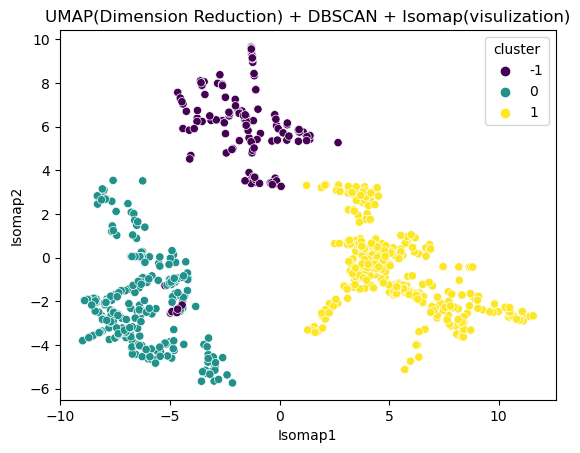

In [124]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2, n_neighbors=5)
data_isomap = isomap.fit_transform(df_umap.drop('cluster', axis=1))

df_isomap = pd.DataFrame(data=data_isomap, columns=['Isomap1', 'Isomap2'])

df_isomap['cluster'] = df_umap['cluster']

sns.scatterplot(data=df_isomap, x='Isomap1', y='Isomap2', hue='cluster', palette='viridis')
plt.title('UMAP(Dimension Reduction) + DBSCAN + Isomap(visulization)')
plt.show()

<h1>Gaussian Mixture Models (GMM) </h1>

In [204]:
from sklearn.mixture import GaussianMixture
import numpy as np

if 'cluster' in df_umap.columns:
    df_umap = df_umap.drop('cluster', axis=1)

gmm = GaussianMixture(n_components=3, random_state=0)

df_umap['cluster'] = gmm.fit_predict(df_umap)
data['cluster'] = df_umap['cluster']

In [205]:
show_scores(df_umap, 'cluster')

cluster
Silhouette Score:  0.536028
Calinski-Harabasz Score:  1349.4105589710377
Davies-Bouldin Score:  0.6039325241474248


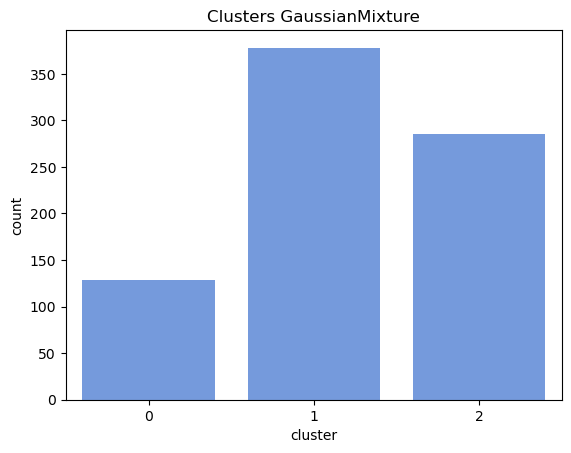

In [206]:
df_umap['cluster'].value_counts()

#clusters barplot
sns.countplot(data=df_umap, x='cluster', color='cornflowerblue')
plt.title('Clusters GaussianMixture')
plt.show()


plot with pca

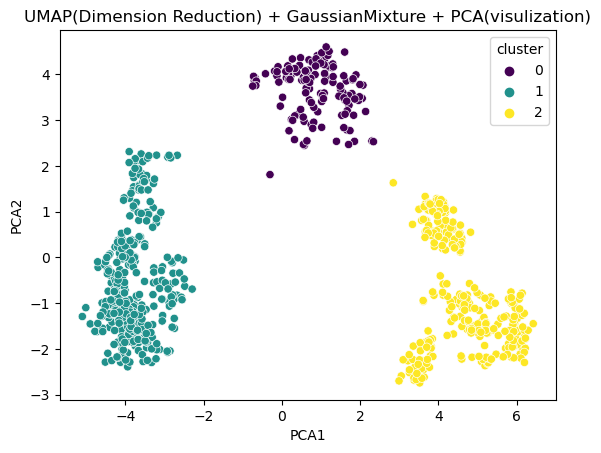

In [207]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(df_umap.drop('cluster', axis=1))

df_pca = pd.DataFrame(data=data_pca, columns=['PCA1', 'PCA2'])

df_pca['cluster'] = df_umap['cluster']

sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='cluster', palette='viridis')
plt.title('UMAP(Dimension Reduction) + GaussianMixture + PCA(visulization)')
plt.show()

plot with t-sne

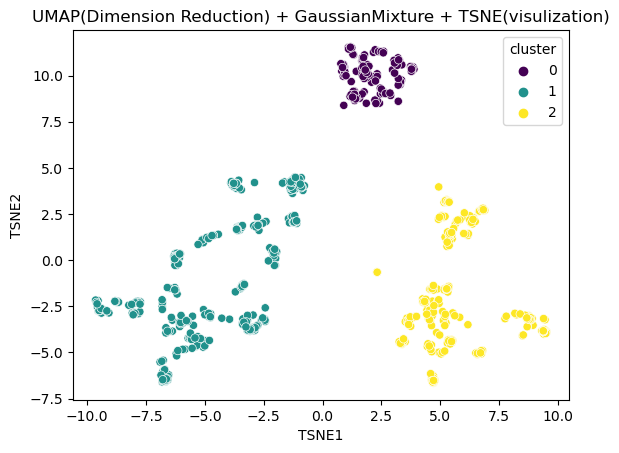

In [209]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, perplexity=90, n_iter=300)
data_tsne = tsne.fit_transform(df_umap.drop('cluster', axis=1))

df_tsne = pd.DataFrame(data=data_tsne, columns=['TSNE1', 'TSNE2'])

df_tsne['cluster'] = df_umap['cluster']

sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='cluster', palette='viridis')
plt.title('UMAP(Dimension Reduction) + GaussianMixture + TSNE(visulization)')
plt.show()


plot with mds

/Users/katebokhan/anaconda3/envs/6.86x/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



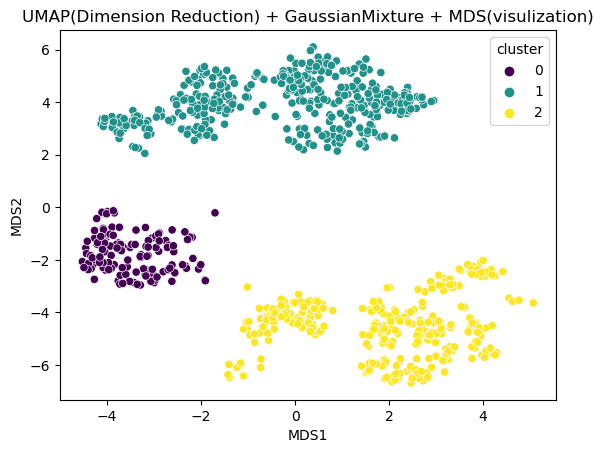

In [210]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=0)
data_mds = mds.fit_transform(df_umap.drop('cluster', axis=1))

df_mds = pd.DataFrame(data=data_mds, columns=['MDS1', 'MDS2'])

df_mds['cluster'] = df_umap['cluster']

sns.scatterplot(data=df_mds, x='MDS1', y='MDS2', hue='cluster', palette='viridis')
plt.title('UMAP(Dimension Reduction) + GaussianMixture + MDS(visulization)')
plt.show()


<h1> Spectral Clustering</h1>

In [211]:
from sklearn.cluster import SpectralClustering

if 'cluster' in df_umap.columns:
    df_umap = df_umap.drop('cluster', axis=1)

sc = SpectralClustering(n_clusters=3, random_state=42, affinity='poly', n_init=100)

df_umap['cluster'] = sc.fit_predict(df_umap)
data['cluster'] = df_umap['cluster']

In [213]:
show_scores(df_umap, 'cluster')

cluster
Silhouette Score:  0.52342284
Calinski-Harabasz Score:  1301.8912352028942
Davies-Bouldin Score:  0.6611471859074306


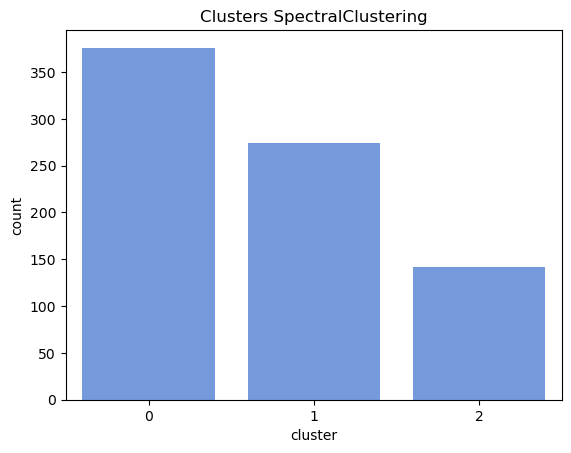

In [215]:
df_umap['cluster'].value_counts()

#clusters barplot
sns.countplot(data=df_umap, x='cluster', color='cornflowerblue')
plt.title('Clusters SpectralClustering')
plt.show()


plot with pca

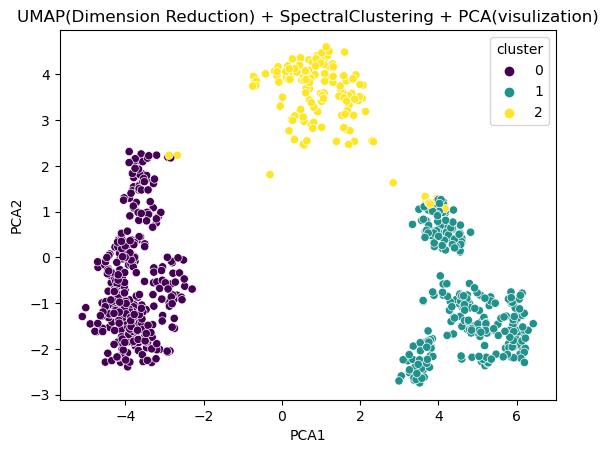

In [216]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(df_umap.drop('cluster', axis=1))

df_pca = pd.DataFrame(data=data_pca, columns=['PCA1', 'PCA2'])

df_pca['cluster'] = df_umap['cluster']

sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='cluster', palette='viridis')
plt.title('UMAP(Dimension Reduction) + SpectralClustering + PCA(visulization)')
plt.show()


plot with t-sne

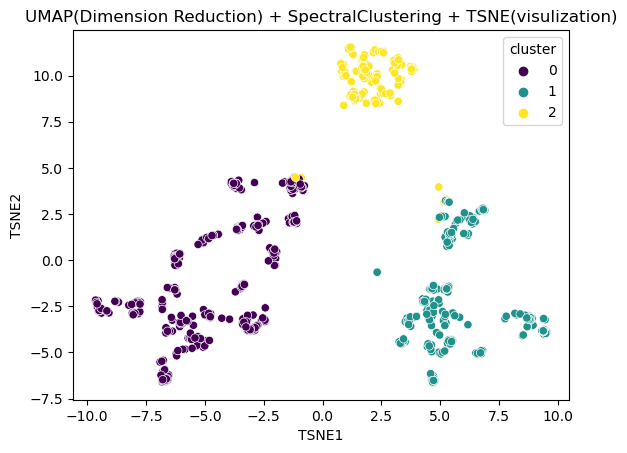

In [217]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, perplexity=90, n_iter=300)
data_tsne = tsne.fit_transform(df_umap.drop('cluster', axis=1))

df_tsne = pd.DataFrame(data=data_tsne, columns=['TSNE1', 'TSNE2'])

df_tsne['cluster'] = df_umap['cluster']

sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='cluster', palette='viridis')
plt.title('UMAP(Dimension Reduction) + SpectralClustering + TSNE(visulization)')
plt.show()


plot with mds

/Users/katebokhan/anaconda3/envs/6.86x/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



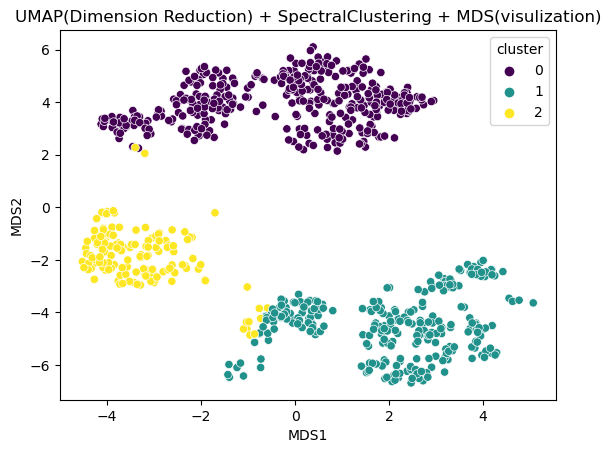

In [218]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=0)
data_mds = mds.fit_transform(df_umap.drop('cluster', axis=1))

df_mds = pd.DataFrame(data=data_mds, columns=['MDS1', 'MDS2'])

df_mds['cluster'] = df_umap['cluster']

sns.scatterplot(data=df_mds, x='MDS1', y='MDS2', hue='cluster', palette='viridis')
plt.title('UMAP(Dimension Reduction) + SpectralClustering + MDS(visulization)')
plt.show()


<h1> EXPLORATION OF CLUSTERS</h1>

In [137]:
# from all these methods we can see that most of them are simular, so lets choose for exploration the
#  AgglomerativeClustering and DBSCAN

<h1>AgglomerativeClustering</h1>

In [138]:
from sklearn.cluster import AgglomerativeClustering

if 'cluster' in df_umap.columns:
    df_umap = df_umap.drop('cluster', axis=1)

agg = AgglomerativeClustering(n_clusters=3)

df_umap['cluster'] = agg.fit_predict(df_umap)
data['cluster'] = df_umap['cluster']

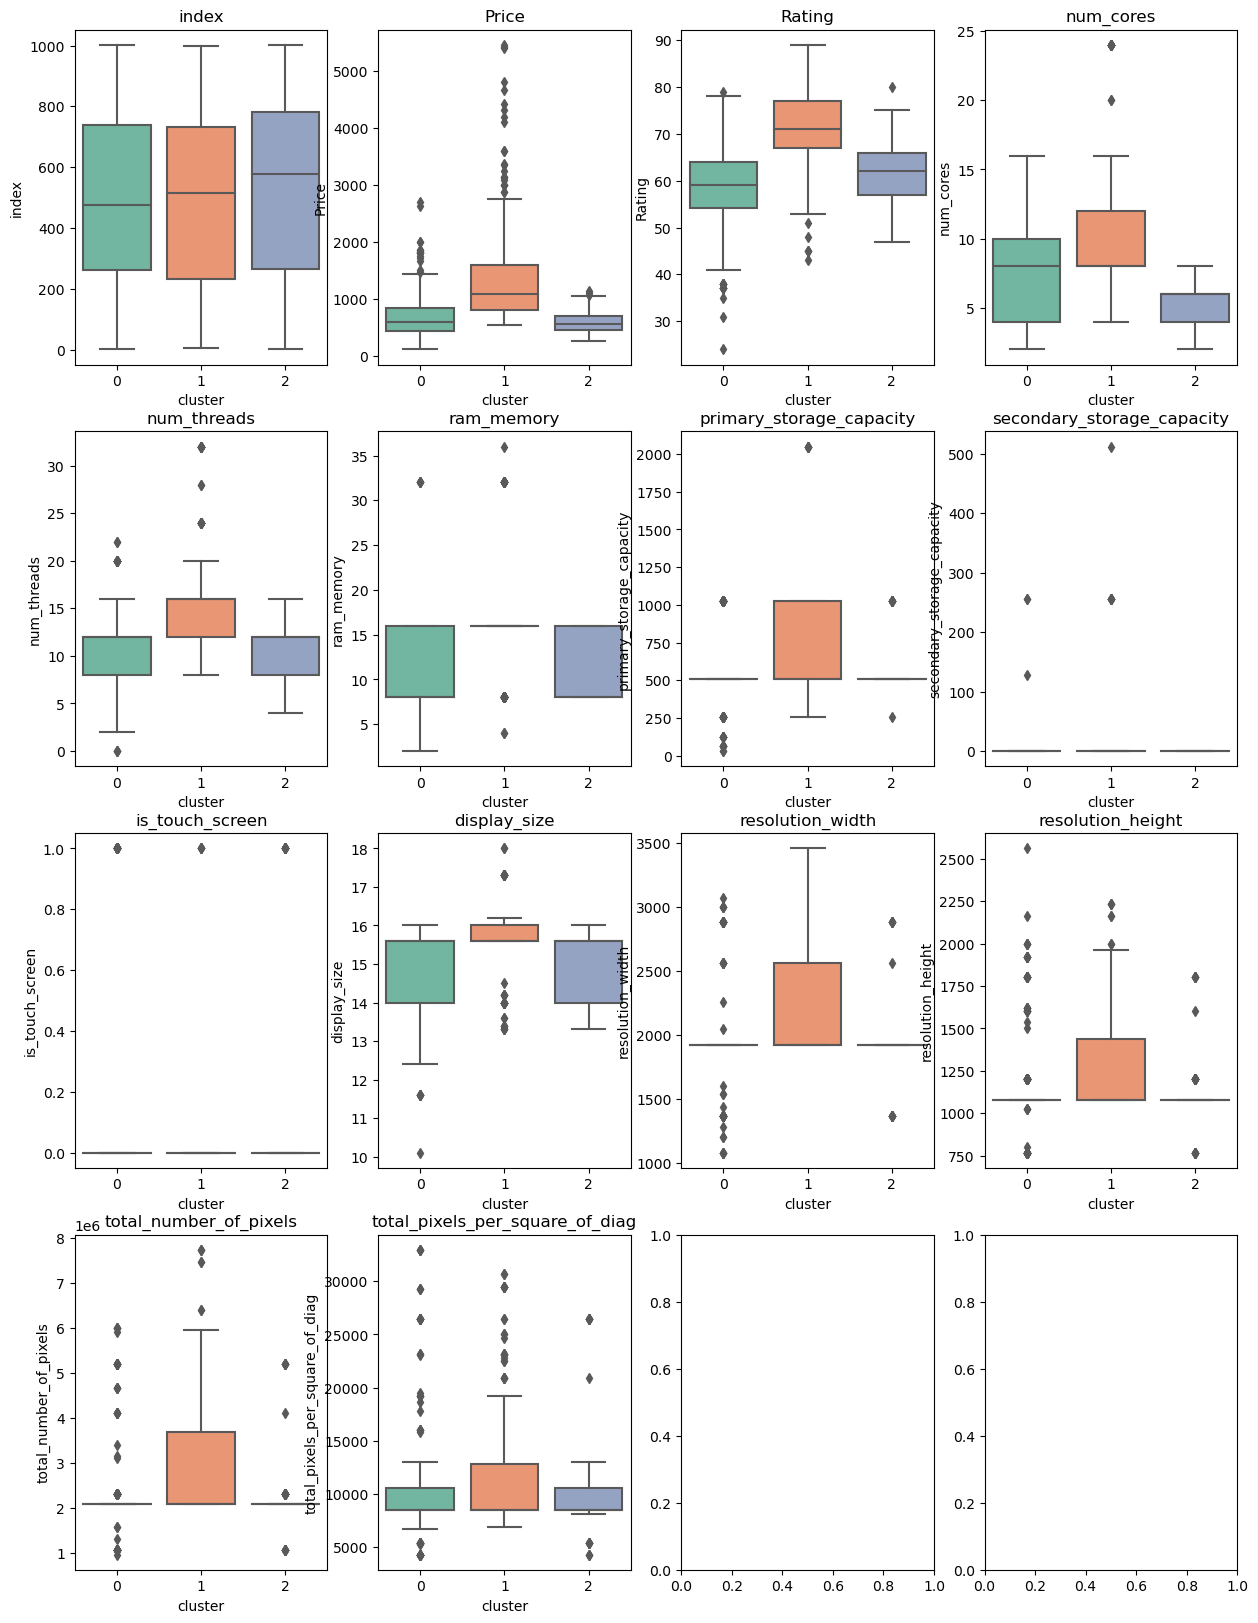

In [139]:
fig, axes = plt.subplots(4, 4, figsize=(15, 4 * 5))

axes = axes.flatten()

i=0
for column in data.columns:
    if column != 'cluster' and (type(data[column][0]) == np.float64 or type(data[column][0]) == np.int64):
        sns.boxplot(x='cluster', y=column, data=data, ax = axes[i], palette="Set2")
        axes[i].set_title(column)
        i+=1

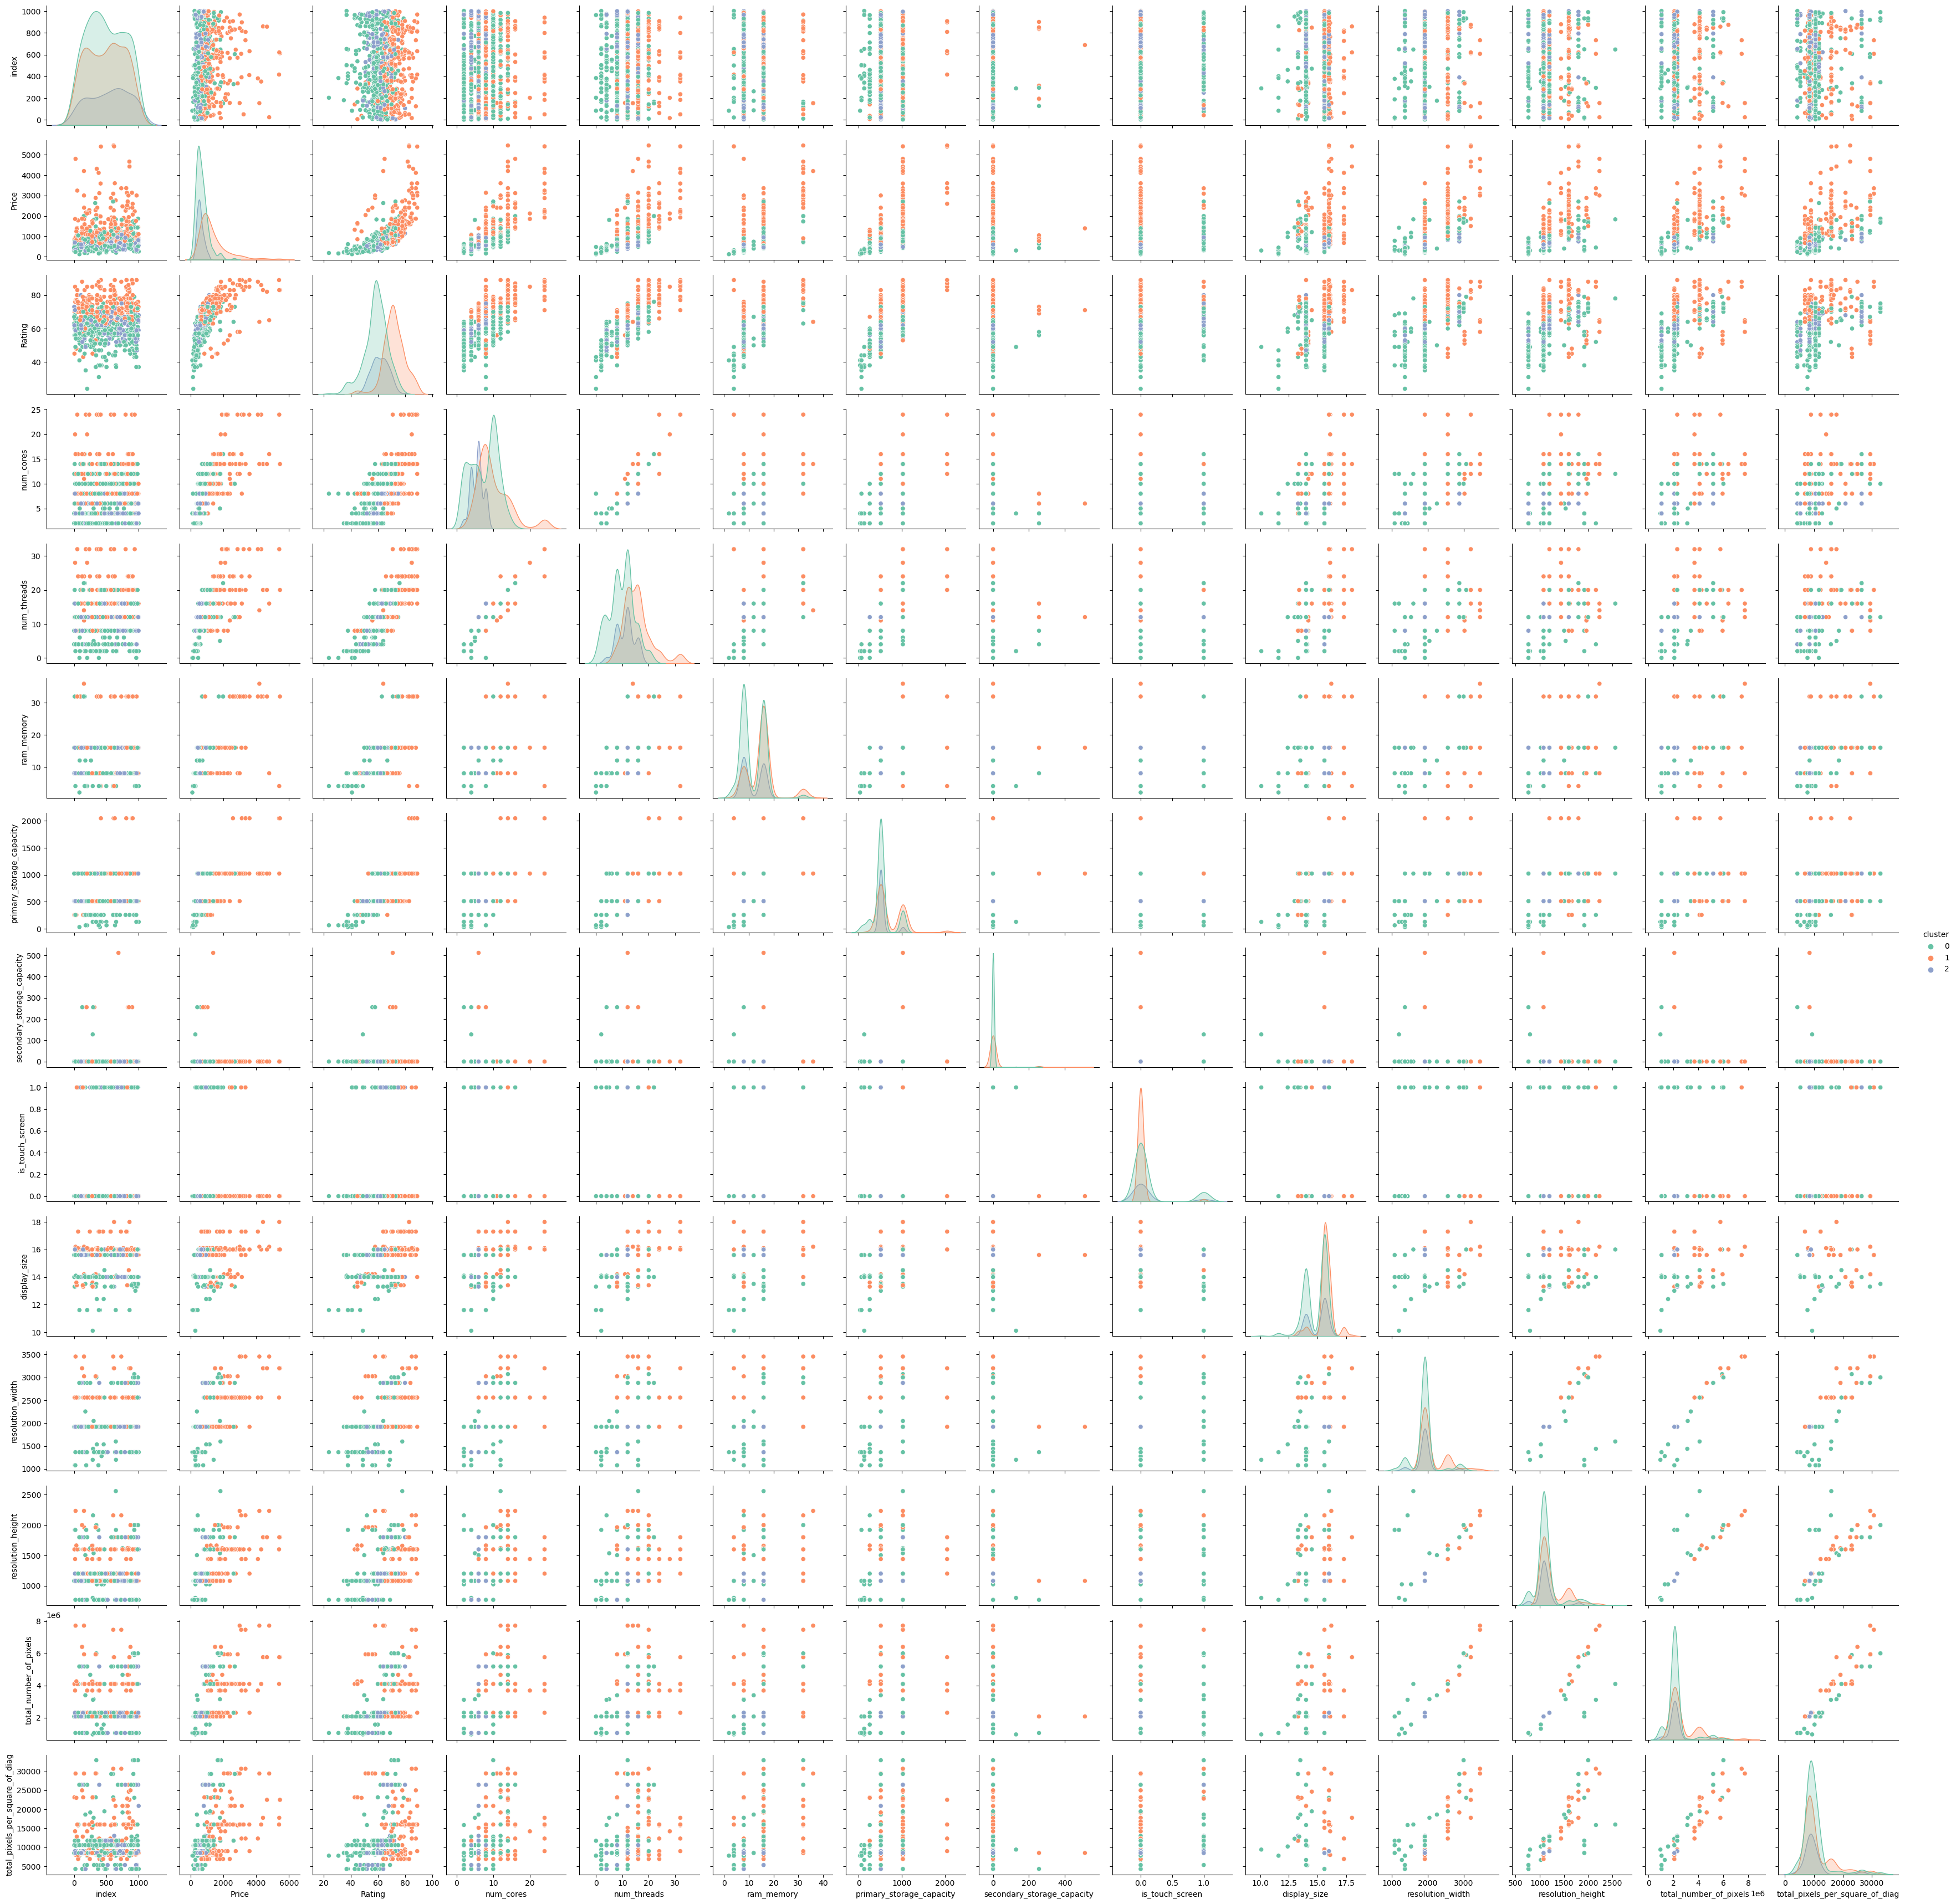

In [140]:
sns.pairplot(data, hue='cluster', palette="Set2")

/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_87271/2125141623.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_87271/2125141623.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_87271/2125141623.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_87271/2125141623.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_87271/2125141623.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_87271/2125141623.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/y9/p941jysn0ddb8zkx38rpntd8

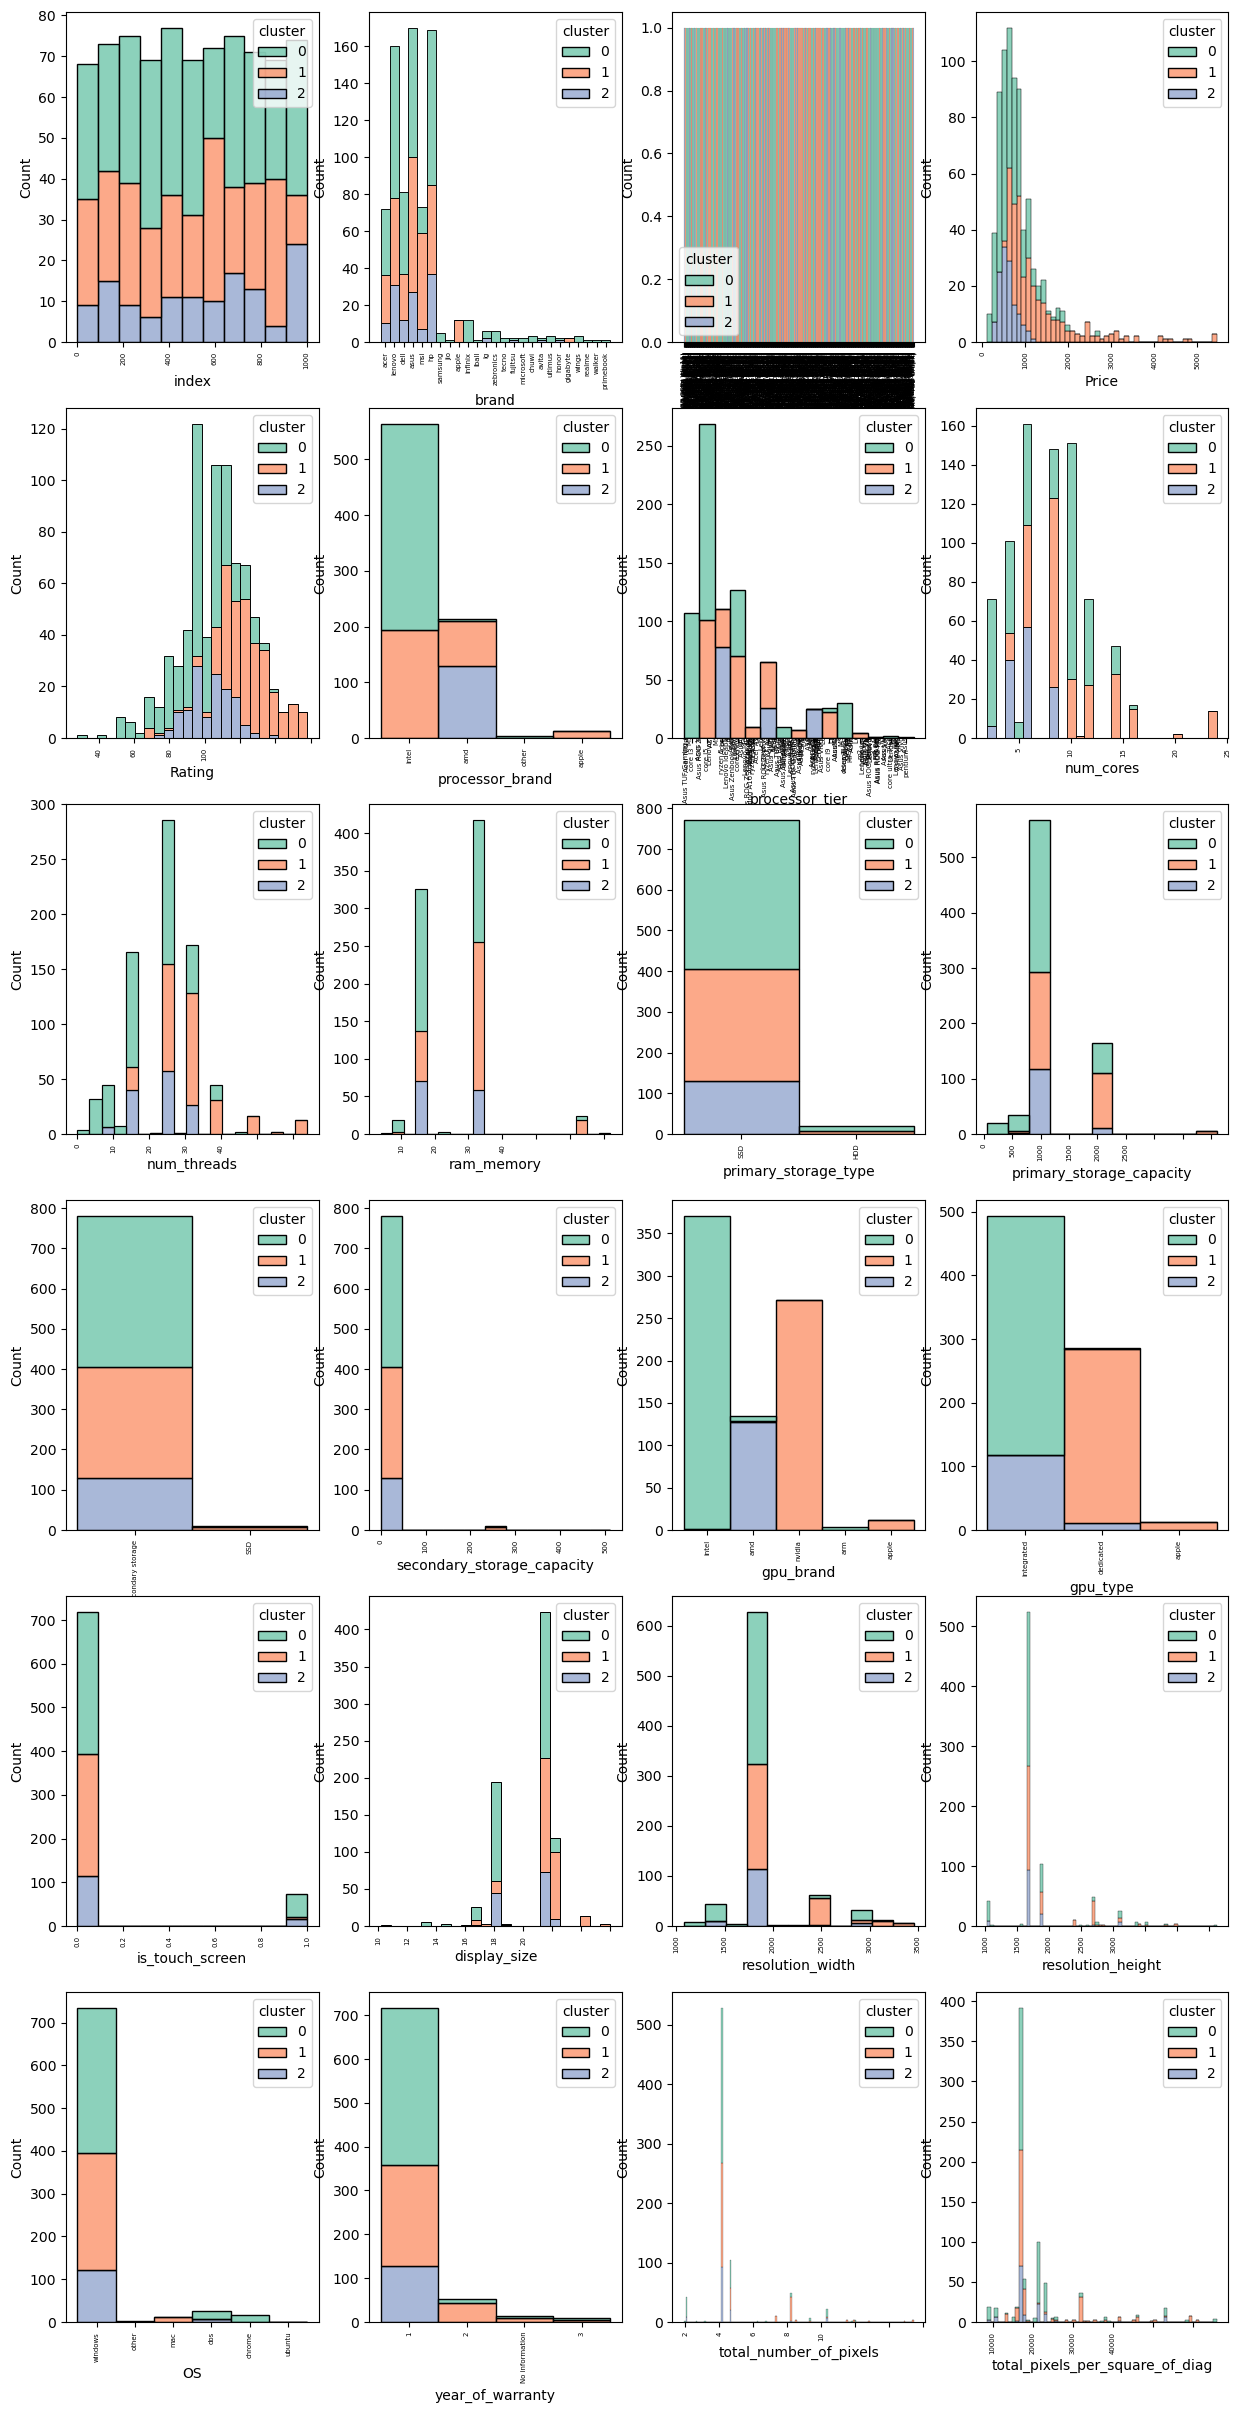

In [141]:
fig, axes = plt.subplots(6, 4, figsize=(15, 6 * 5))

axes = axes.flatten()

i=0

for i, column in enumerate(data.columns):
    if column != 'cluster' :
        sns.histplot(data=data, x=column, hue="cluster", multiple="stack", ax=axes[i], palette='Set2')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
        axes[i].tick_params(axis='x', labelsize=5)
        axes[i].set_xlabel(column)
        i+=1

In [142]:
import plotly.express as px

fig = px.histogram(data, x='brand', color='cluster')
fig.show()

<h1> DBSCAN </h1>

In [143]:
import optuna
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import pandas as pd
import numpy as np

np.random.seed(42)

if 'cluster' in df_umap.columns:
    df_umap = df_umap.drop('cluster', axis=1)

def objective(trial):
    eps = trial.suggest_loguniform('eps', 0.001, 3.0)
    min_samples = trial.suggest_int('min_samples', 2, 60)
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(df_umap)
    
    if len(set(cluster_labels)) > 1:
        silhouette = silhouette_score(df_umap, cluster_labels)
        calinski = calinski_harabasz_score(df_umap, cluster_labels)
        
        score = 0.5 * silhouette + 0.5 * calinski
    else:
        score = -1  
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

print(f'Best parameters: {study.best_params}')
print(f'Best score: {study.best_value}')

best_params = study.best_params

dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
df_umap['cluster'] = dbscan.fit_predict(df_umap)
data['cluster'] = df_umap['cluster']


[I 2024-05-30 10:54:31,962] A new study created in memory with name: no-name-e4536548-40c9-45b6-9dc9-660ffeed7cef
/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_87271/3499533163.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2024-05-30 10:54:31,990] Trial 0 finished with value: 0.6774057216786131 and parameters: {'eps': 0.3472795679449518, 'min_samples': 2}. Best is trial 0 with value: 0.6774057216786131.
/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_87271/3499533163.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2024-05-30 10:54:32,009] Trial 1 finished with value: -1.0 and parameters: {'eps': 1.1114319328306959, 'min_samples'

Best parameters: {'eps': 1.9733541443088924, 'min_samples': 42}
Best score: 480.25676267654467


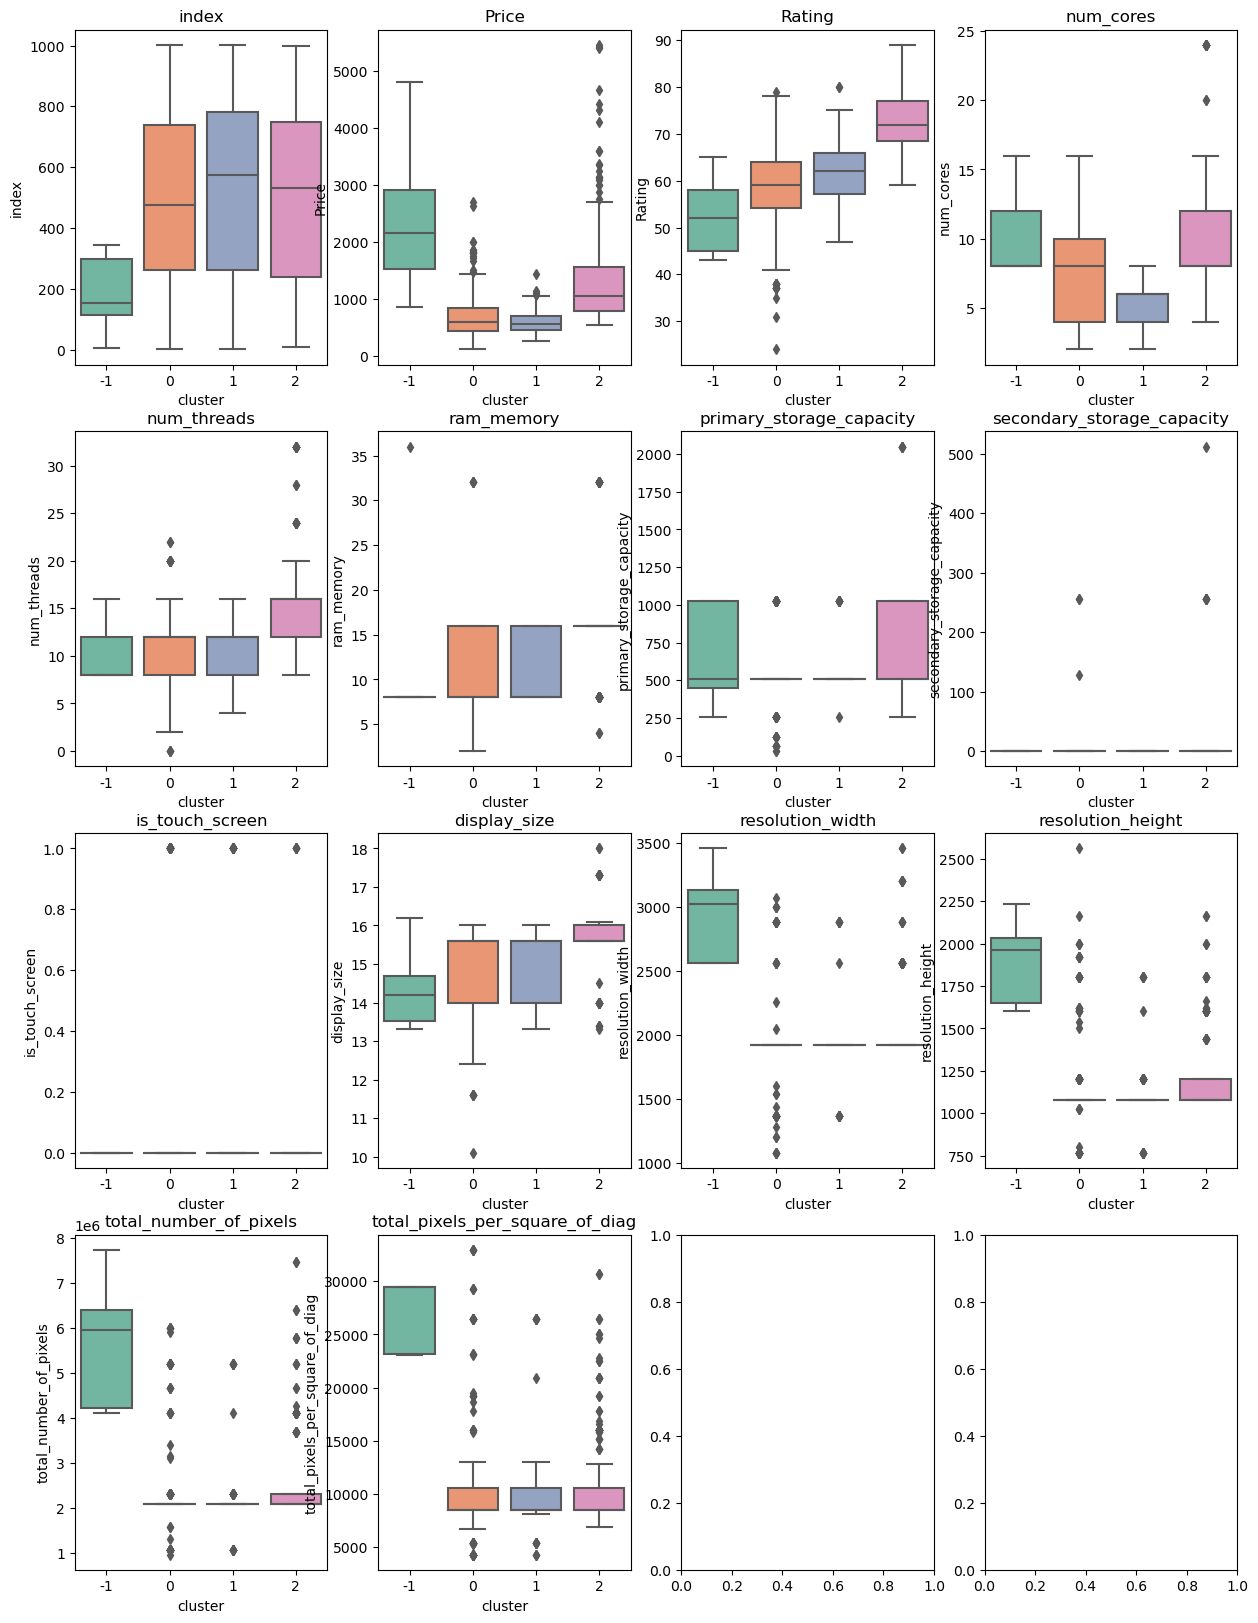

In [144]:
fig, axes = plt.subplots(4, 4, figsize=(15, 4 * 5))

axes = axes.flatten()

i=0
for column in data.columns:
    if column != 'cluster' and (type(data[column][0]) == np.float64 or type(data[column][0]) == np.int64):
        sns.boxplot(x='cluster', y=column, data=data, ax = axes[i], palette="Set2")
        axes[i].set_title(column)
        i+=1

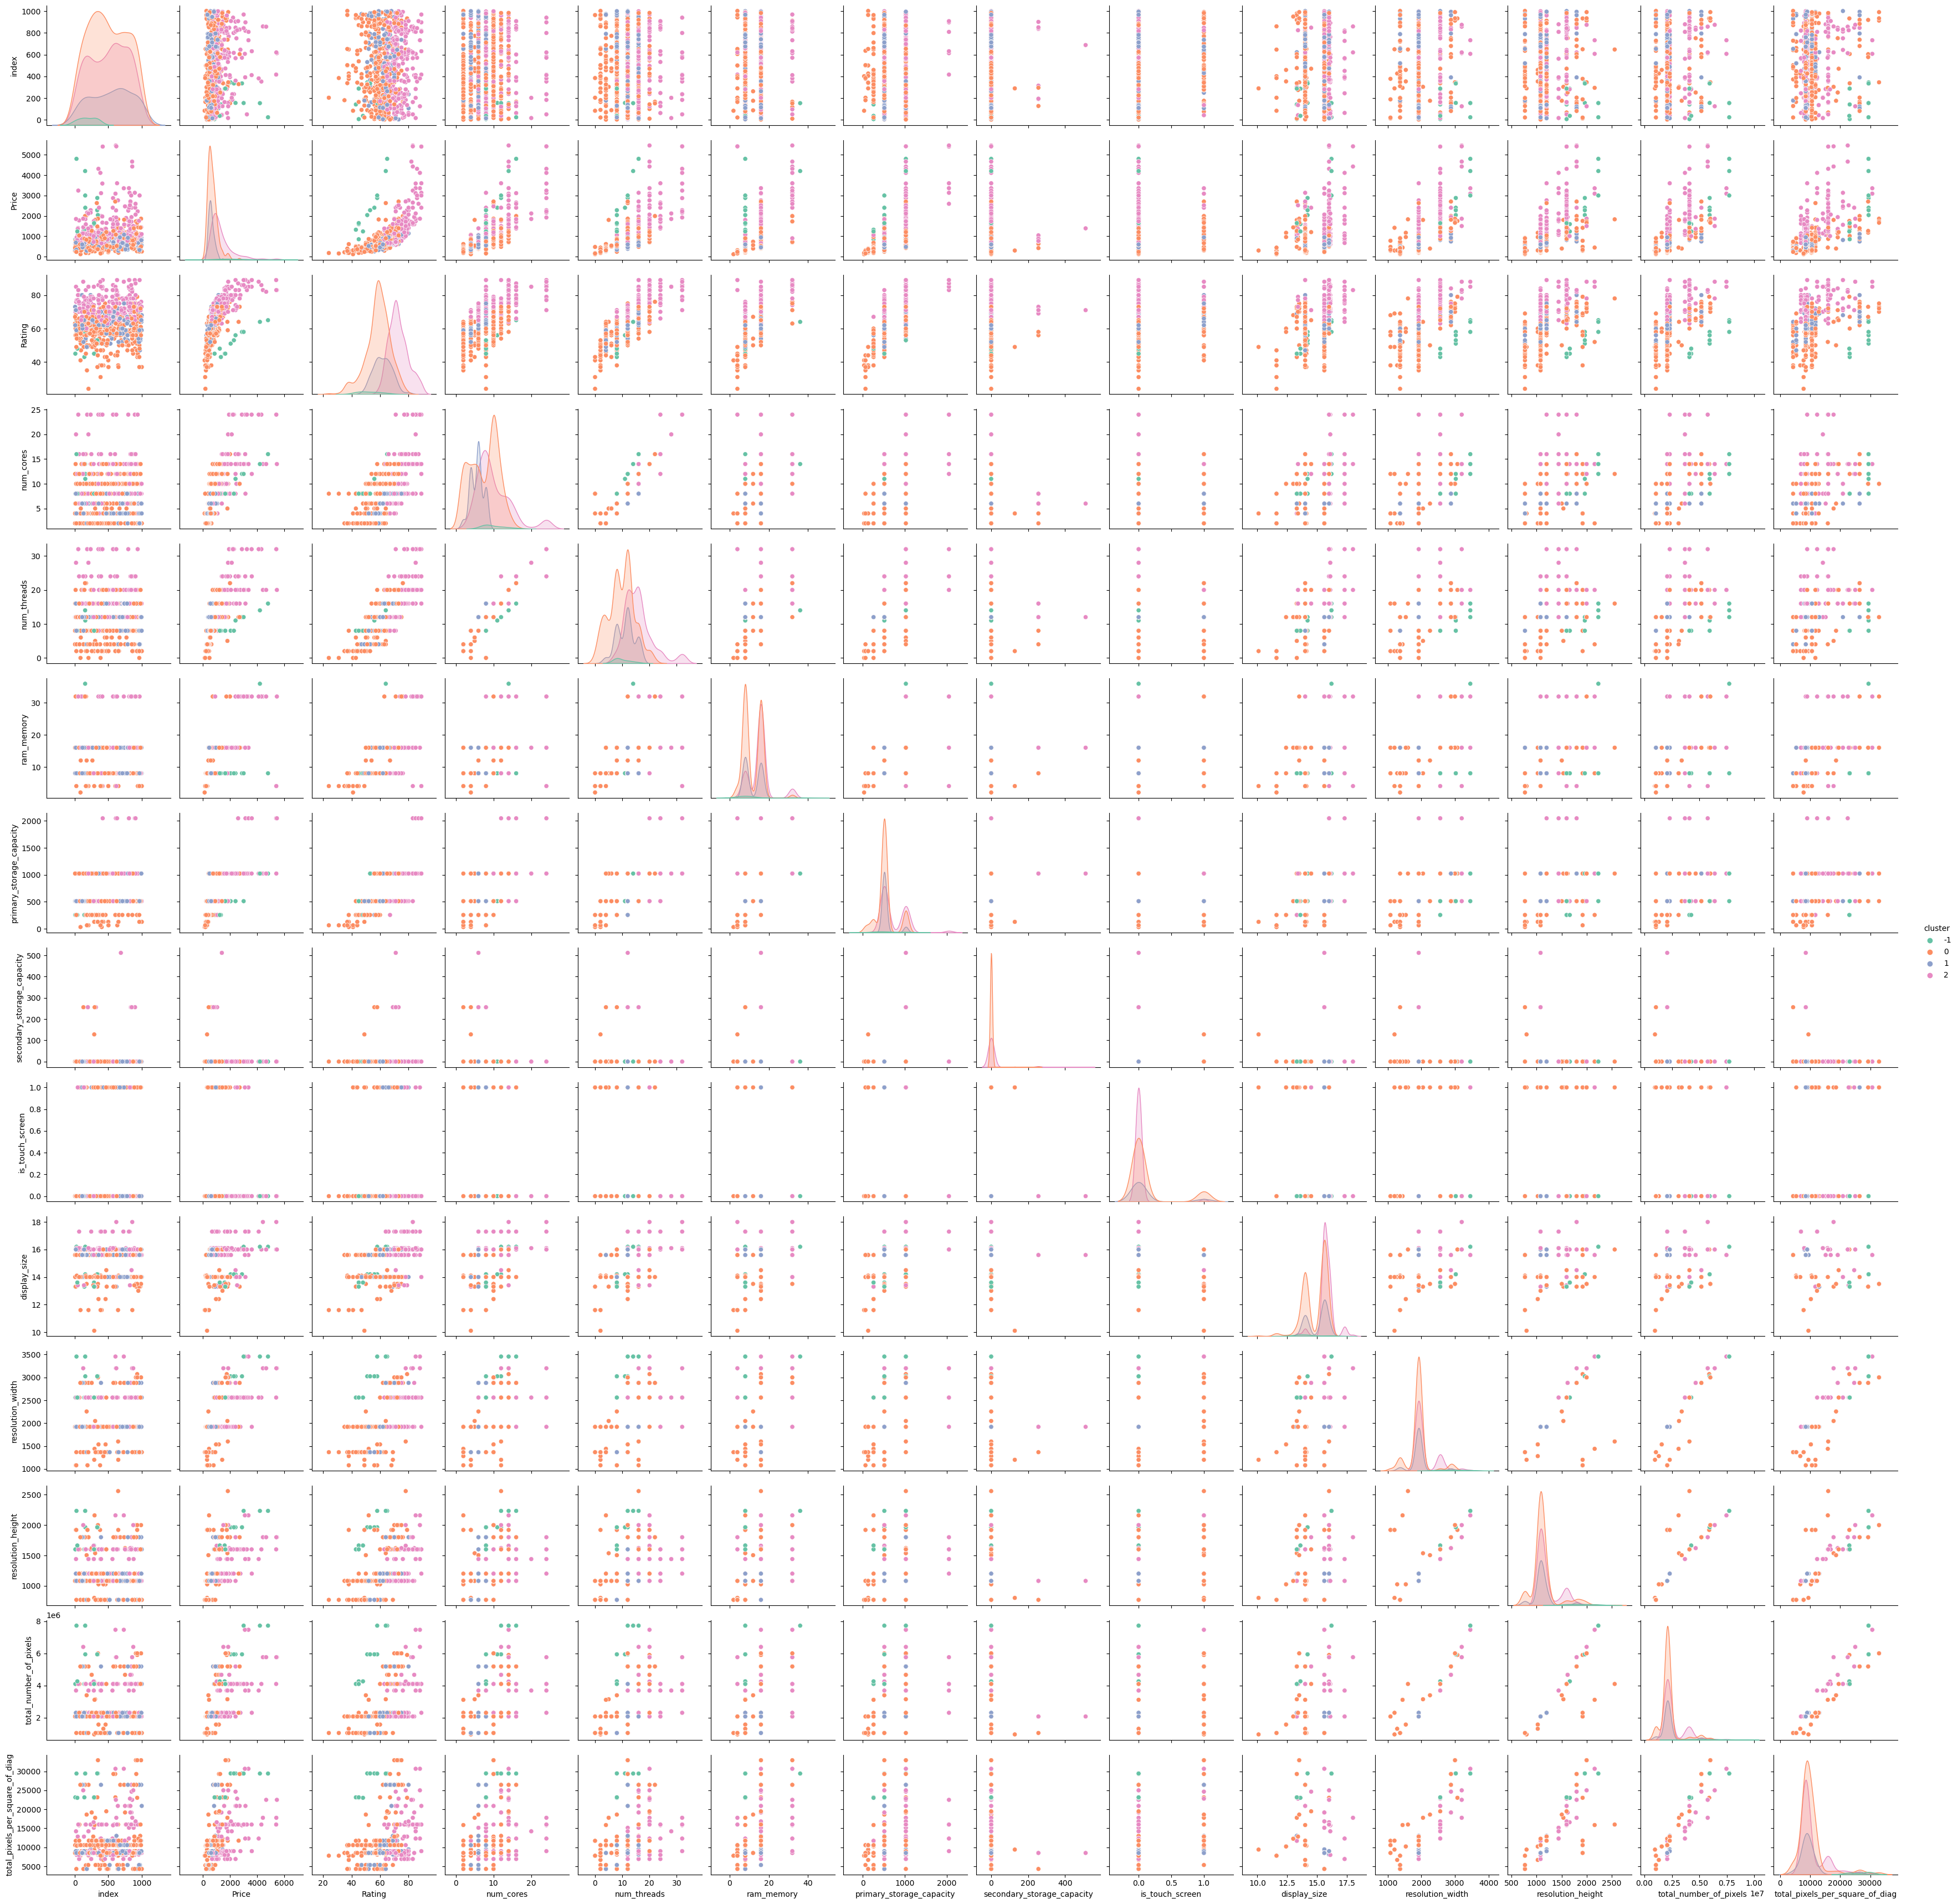

In [145]:
sns.pairplot(data, hue='cluster', palette="Set2")

/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_87271/2125141623.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_87271/2125141623.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_87271/2125141623.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_87271/2125141623.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_87271/2125141623.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/y9/p941jysn0ddb8zkx38rpntd80000gn/T/ipykernel_87271/2125141623.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/y9/p941jysn0ddb8zkx38rpntd8

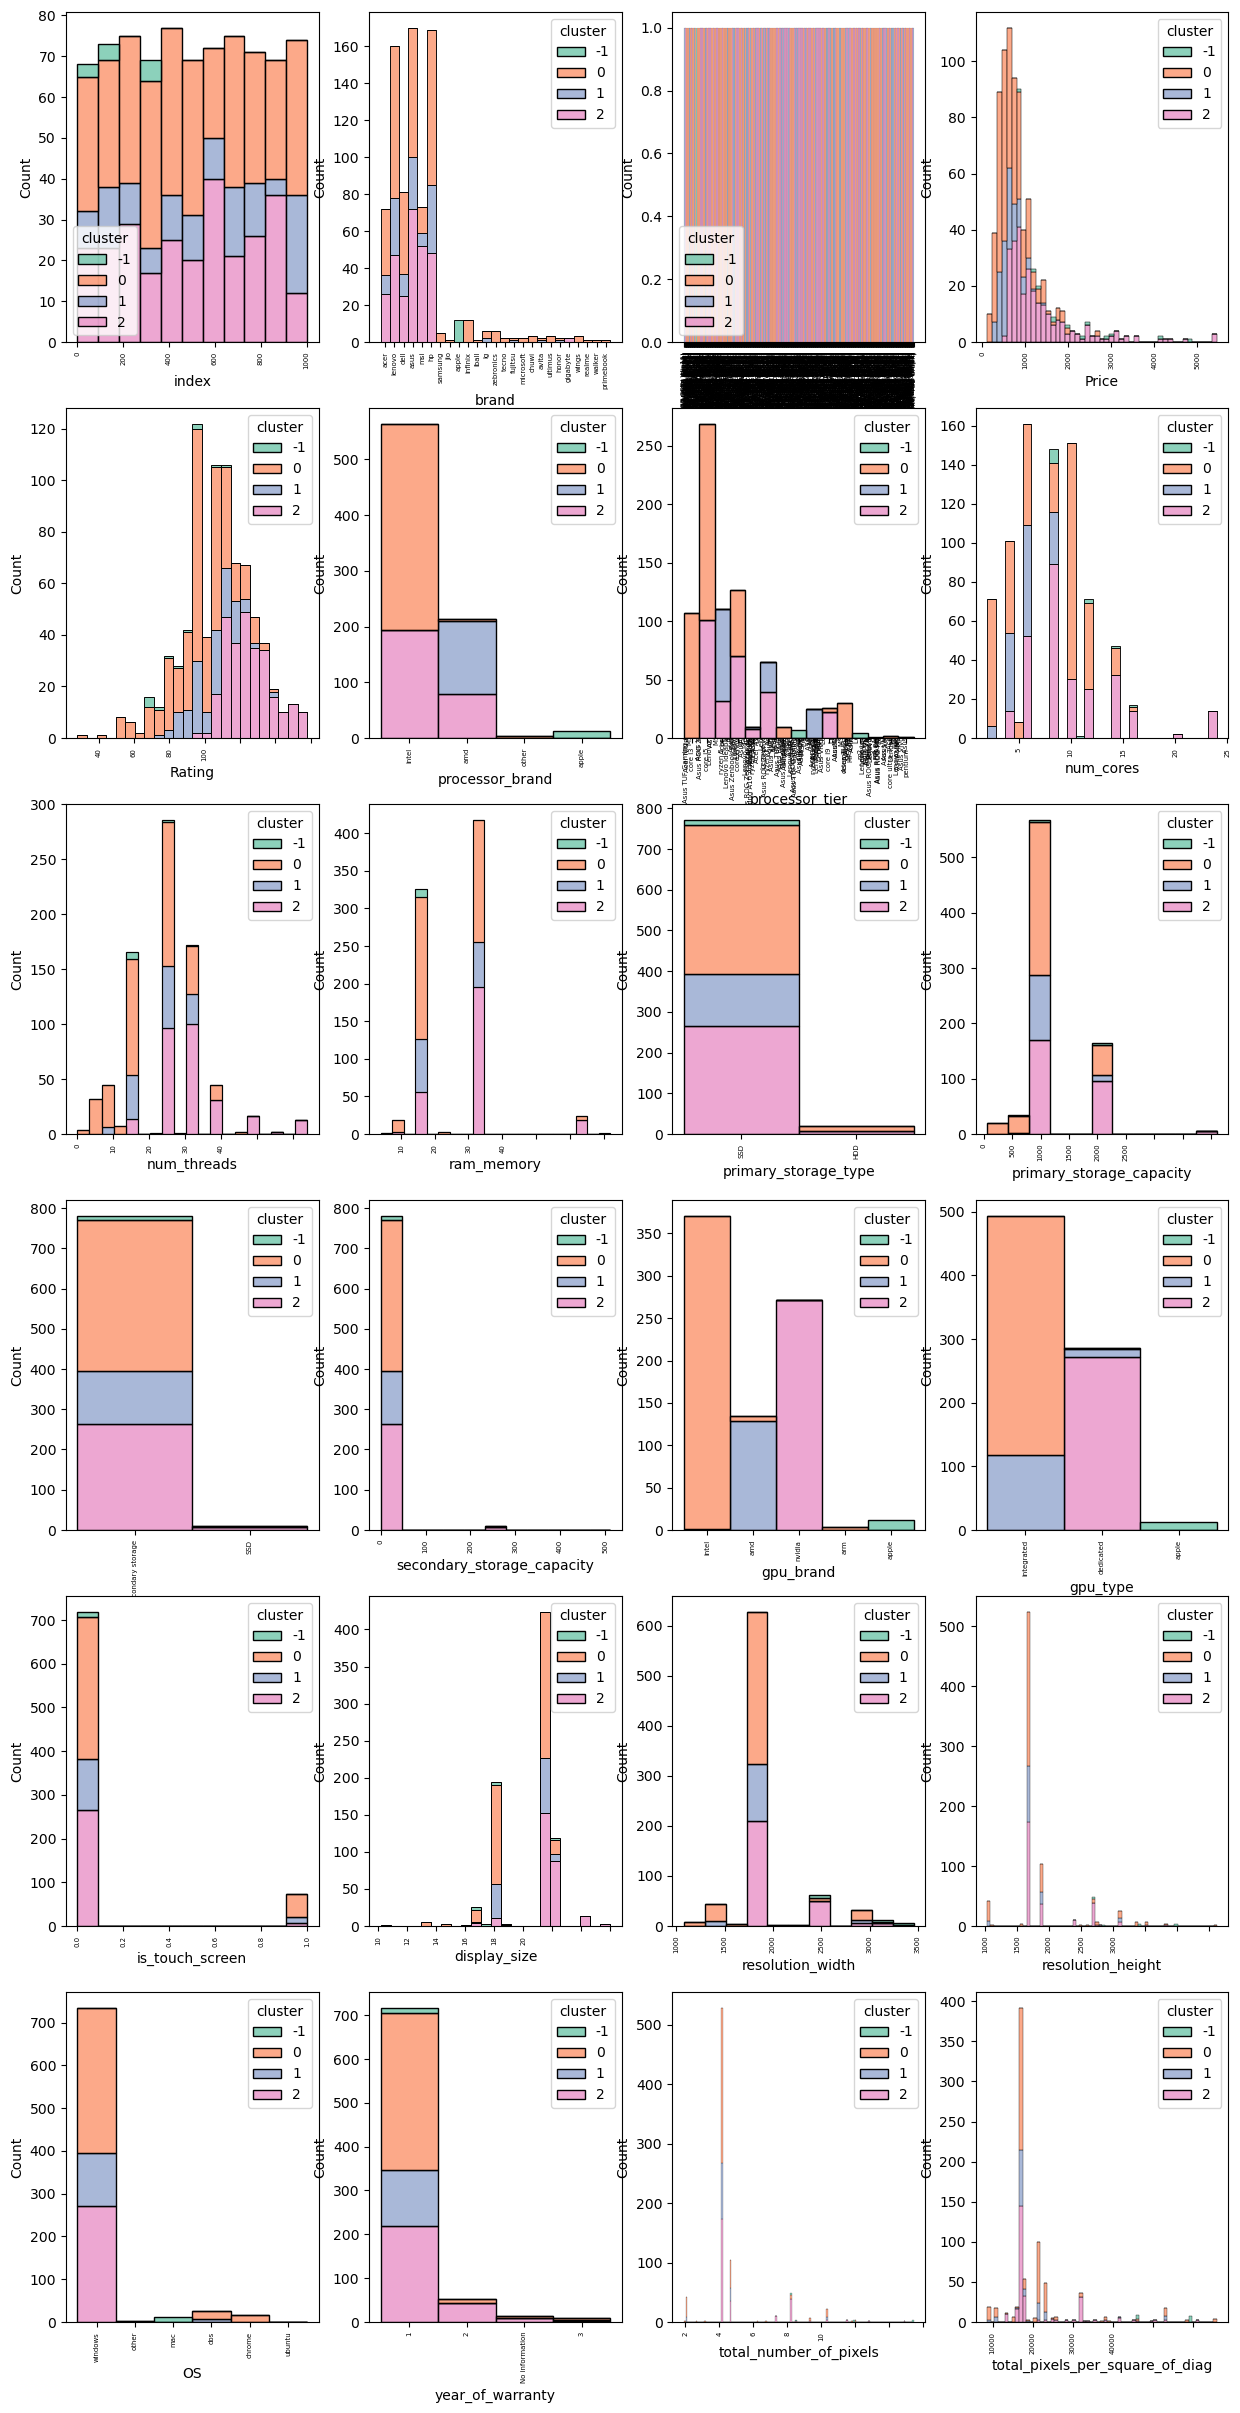

In [146]:
fig, axes = plt.subplots(6, 4, figsize=(15, 6 * 5))

axes = axes.flatten()

i=0

for i, column in enumerate(data.columns):
    if column != 'cluster' :
        sns.histplot(data=data, x=column, hue="cluster", multiple="stack", ax=axes[i], palette='Set2')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
        axes[i].tick_params(axis='x', labelsize=5)
        axes[i].set_xlabel(column)
        i+=1

In [147]:
import plotly.express as px

fig = px.histogram(data, x='brand', color='cluster')
fig.show()